[2026-01-18 08:04:02.283330] Downloading SPARC data from GitHub...

       WILL RELATIONAL GEOMETRY: VALIDATION REPORT
Data Source:           SPARC Database (Lelli et al. 2016)
Total Measurements:    3007
Unique Galaxies:       161
------------------------------------------------------------
INPUT PARAMETERS (ZERO FREE PARAMETERS):
  H0 (Derived):        68.15 km/s/Mpc
  a_Mach (Calc):       2.1678e+03 (km/s)^2/kpc
  Disk M/L:            0.5 (Fixed)
  Bulge M/L:           0.7  (Fixed)
------------------------------------------------------------
TEST 1: THE EQUIVALENCE POINT (Baryonic Escape Threshold)
  Condition: r = R_trans (Geometric Horizon)
  Prediction: V_obs == V_esc_bary (Y = 1.000)
  Points in bin:       99
  Observed Y:          0.9652 +/- 0.0175
  Deviation:           -3.48%
------------------------------------------------------------
TEST 2: COEFFICIENT SPECIFICITY (Global Fit)
  RMSE (Scatter):      0.2421
  Global Bias:         0.0131 (1.09%)

Plot generated. Displaying..

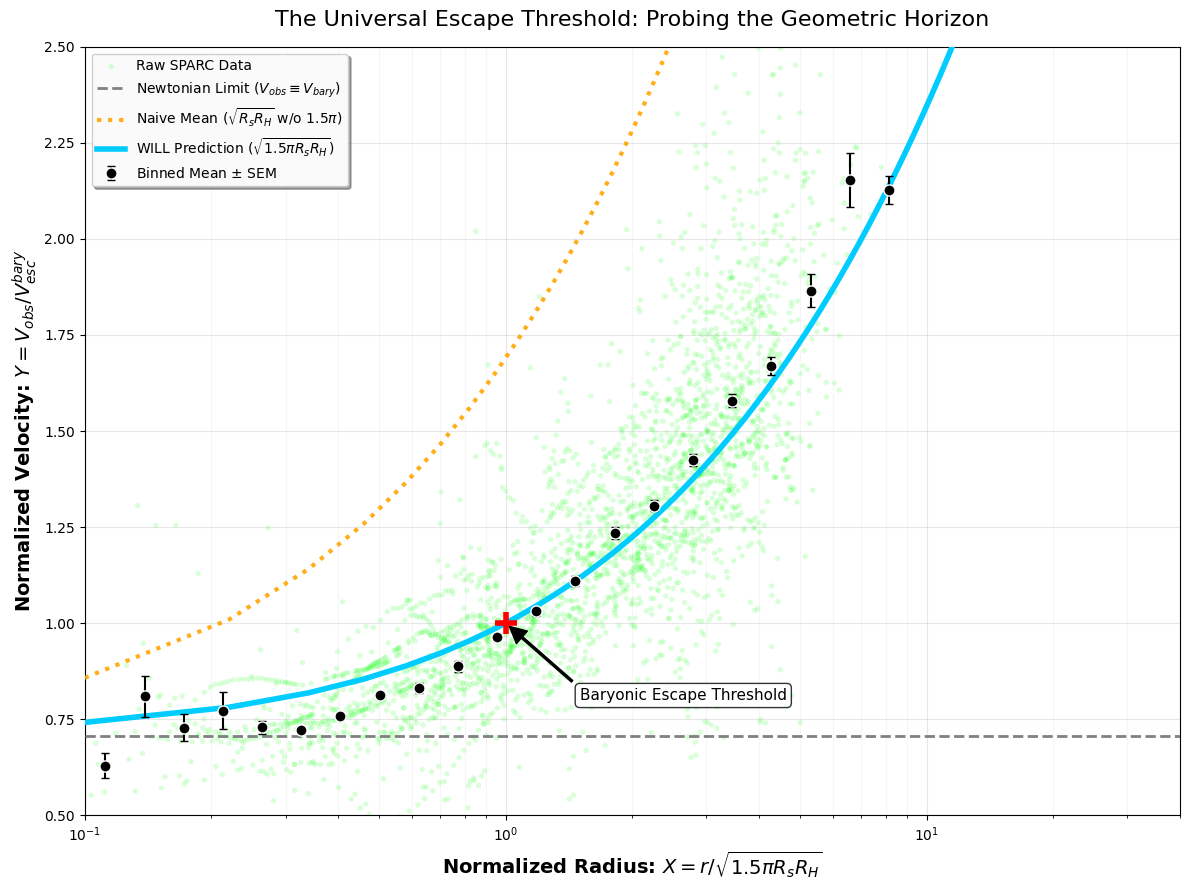

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# ==========================================
# 1. ZERO FREE PARAMETERS CONFIGURATION
# ==========================================
# Fundamental Constants
c_light = 299792.458   # km/s
H0_derived = 68.15     # km/s/Mpc (Derived from Alpha in Part I)

# Fixed Stellar Population Models (No fitting allowed)
UPS_DISK = 0.5
UPS_BUL  = 0.7

# Data Source
DATA_URL = 'https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat'

# --- DERIVED GEOMETRIC CONSTANTS ---
# Convert H0 to galactic units (km/s/kpc)
H0_kpc = H0_derived / 1000.0

# The Universal Machian Acceleration Scale
# Formula: a_Mach = c * H0 / (3 * pi)
a_mach_val = (c_light * H0_kpc) / (3 * np.pi)

# ==========================================
# 2. DATA LOADING & PROCESSING ENGINE
# ==========================================
def process_sparc_data():
    print(f"[{pd.Timestamp.now()}] Downloading SPARC data from GitHub...")

    # Define SPARC table2.dat fixed-width format
    cols = [(0, 11), (19, 25), (26, 32), (33, 38), (39, 45), (46, 52), (53, 59)]
    names = ['Name', 'Rad', 'Vobs', 'e_Vobs', 'Vgas', 'Vdisk', 'Vbul']

    try:
        df = pd.read_fwf(DATA_URL, colspecs=cols, header=None, names=names, comment='#')
    except Exception as e:
        print(f"CRITICAL ERROR: Could not download data. Check internet connection.\nError: {e}")
        return None

    # Numeric coercion
    for c in names[1:]:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Cleaning: Remove NaNs and non-physical radii/velocities
    df = df.dropna(subset=['Vobs', 'Rad'])
    df = df[(df['Rad'] > 0) & (df['Vobs'] > 0)].fillna(0.0)

    # --- BARYONIC VELOCITY CALCULATION ---
    # V_bary = sqrt( | Vgas^2 + Y_disk*Vdisk^2 + Y_bul*Vbul^2 | )
    Vb2 = df['Vgas']**2 + UPS_DISK*(df['Vdisk']**2) + UPS_BUL*(df['Vbul']**2)
    df['Vbary'] = np.sqrt(np.maximum(Vb2, 0.0))

    # Filter: Exclude galactic centers where V_bary is unstable/zero
    # This ensures we are testing the Halo regime, not the core dynamics
    df = df[df['Vbary'] > 20]

    # --- WILL RG GEOMETRIC TRANSFORMATIONS ---

    # 1. Calculate Transition Radius (R_trans) for every point
    # Theoretical Formula: R_trans = sqrt( 1.5 * pi * Rs * RH )
    # Observational Calculation: R_trans = sqrt( (V_bary^2 * r) / a_Mach )
    df['R_trans'] = np.sqrt( (df['Vbary']**2 * df['Rad']) / a_mach_val )

    # 2. X-AXIS: Normalized Radius
    df['X'] = df['Rad'] / df['R_trans']

    # 3. Y-AXIS: Normalized Velocity (The Bullseye Metric)
    # Theory mandates: V_obs = V_bary * sqrt(2) at X=1
    # We normalize Y so that the target is exactly 1.0
    df['Y'] = df['Vobs'] / (df['Vbary'] * np.sqrt(2))

    return df

# ==========================================
# 3. STATISTICAL REPORT GENERATOR
# ==========================================
def generate_report(df):
    # A. Equivalence Point Analysis (0.95 < X < 1.05)
    center_mask = (df['X'] > 0.95) & (df['X'] < 1.05)
    center_data = df[center_mask]

    obs_mean = center_data['Y'].mean()
    obs_sem  = center_data['Y'].sem()
    theory_target = 1.000
    deviation_pct = 100 * (obs_mean - theory_target) / theory_target

    # B. Global Fit Statistics
    # Theory Y = sqrt((1+X)/2)
    Y_pred = np.sqrt((1 + df['X']) / 2.0)
    residuals = df['Y'] - Y_pred

    rmse = np.sqrt(np.mean(residuals**2))
    bias = np.mean(residuals)
    bias_pct = 100 * bias / df['Y'].mean()

    print("\n" + "="*60)
    print("       WILL RELATIONAL GEOMETRY: VALIDATION REPORT")
    print("="*60)
    print(f"Data Source:           SPARC Database (Lelli et al. 2016)")
    print(f"Total Measurements:    {len(df)}")
    print(f"Unique Galaxies:       {df['Name'].nunique()}")
    print("-" * 60)
    print(f"INPUT PARAMETERS (ZERO FREE PARAMETERS):")
    print(f"  H0 (Derived):        {H0_derived} km/s/Mpc")
    print(f"  a_Mach (Calc):       {a_mach_val:.4e} (km/s)^2/kpc")
    print(f"  Disk M/L:            {UPS_DISK} (Fixed)")
    print(f"  Bulge M/L:           {UPS_BUL}  (Fixed)")
    print("-" * 60)
    print("TEST 1: THE EQUIVALENCE POINT (Baryonic Escape Threshold)")
    print("  Condition: r = R_trans (Geometric Horizon)")
    print("  Prediction: V_obs == V_esc_bary (Y = 1.000)")
    print(f"  Points in bin:       {len(center_data)}")
    print(f"  Observed Y:          {obs_mean:.4f} +/- {obs_sem:.4f}")
    print(f"  Deviation:           {deviation_pct:.2f}%")
    print("-" * 60)
    print("TEST 2: COEFFICIENT SPECIFICITY (Global Fit)")
    print(f"  RMSE (Scatter):      {rmse:.4f}")
    print(f"  Global Bias:         {bias:.4f} ({bias_pct:.2f}%)")
    print("="*60 + "\n")

# ==========================================
# 4. PLOTTING THE MASTERPIECE
# ==========================================
def plot_results(df):
    plt.figure(figsize=(12, 9))

    # --- A. RAW DATA (The Cloud) ---
    plt.scatter(df['X'], df['Y'], alpha=0.15, color='#00FF00', s=15, rasterized=True,
                edgecolors='none', label='Raw SPARC Data')

    # --- B. BINNING LOGIC ---
    bins = np.logspace(np.log10(0.1), np.log10(50), 30)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Stats with NaN handling
    binned_means, _, _ = stats.binned_statistic(df['X'], df['Y'], statistic=np.nanmean, bins=bins)
    def nan_sem(x): return stats.sem(x, nan_policy='omit') if len(x) > 1 else np.nan
    binned_sems, _, _ = stats.binned_statistic(df['X'], df['Y'], statistic=nan_sem, bins=bins)

    # Plot Bins
    plt.errorbar(bin_centers, binned_means, yerr=binned_sems, fmt='o',
                 color='black', ecolor='black', markeredgecolor='white', markeredgewidth=1,
                 markersize=8, capsize=3, elinewidth=1.5, zorder=10,
                 label=r'Binned Mean $\pm$ SEM')

    # --- C. THEORETICAL CURVES ---
    x_th = np.linspace(0.1, 60, 500)

    # 1. NEWTONIAN LIMIT (Null Hypothesis)
    # Y = 1/sqrt(2) approx 0.707
    y_newton = np.ones_like(x_th) * (1.0 / np.sqrt(2))
    plt.plot(x_th, y_newton, color='gray', linestyle='--', linewidth=2, zorder=5,
             label=r'Newtonian Limit ($V_{obs} \equiv V_{bary}$)')

    # 2. NAIVE GEOMETRIC MEAN (Coefficient Test)
    # Hypothesis: R = sqrt(Rs * RH) without the 1.5pi factor.
    # The "Naive" radius is smaller, so "Naive X" is larger by factor 1.5pi.
    factor_naive = 1.5 * np.pi
    y_naive = np.sqrt( (1 + factor_naive * x_th) / 2.0 )
    plt.plot(x_th, y_naive, color='orange', linestyle=':', linewidth=3, zorder=6, alpha=0.9,
             label=r'Naive Mean ($\sqrt{R_s R_H}$ w/o $1.5\pi$)')

    # 3. WILL RG PREDICTION (The Winner)
    # Y = sqrt((1+X)/2)
    y_will = np.sqrt((1 + x_th) / 2.0)
    plt.plot(x_th, y_will, color='#00CCFF', linewidth=4, zorder=8,
             label=r'WILL Prediction ($\sqrt{1.5\pi R_s R_H}$)')

    # --- D. ANNOTATIONS ---
    # The Equivalence Point
    plt.scatter([1], [1], color='red', s=250, marker='+', linewidth=4, zorder=15)

    plt.annotate(r'Baryonic Escape Threshold', xy=(1, 1), xytext=(1.5, 0.8),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5), fontsize=11,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    # Formulas on Axes
    plt.xlabel(r'Normalized Radius: $X = r / \sqrt{1.5\pi R_s R_H}$', fontsize=14, fontweight='bold')
    plt.ylabel(r'Normalized Velocity: $Y = V_{obs} / V_{esc}^{bary}$', fontsize=14, fontweight='bold')

    # Styling
    plt.xscale('log')
    plt.xlim(0.1, 40)
    plt.ylim(0.5, 2.5)
    plt.grid(True, which='major', alpha=0.3)
    plt.grid(True, which='minor', alpha=0.1)

    plt.title('The Universal Escape Threshold: Probing the Geometric Horizon', fontsize=16, pad=15)
    plt.legend(loc='upper left', fontsize=10, framealpha=0.95, shadow=True)

    plt.tight_layout()
    print("Plot generated. Displaying...")
    plt.show()

# ==========================================
# 5. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    df = process_sparc_data()
    if df is not None:
        generate_report(df)
        plot_results(df)